In [9]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import seaborn as sns


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc,f1_score, precision_score, recall_score
import xgboost as xgb
from xgboost import plot_importance


from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import time
import itertools
import shap
import pickle

from optbinning import OptimalBinning

from sklearn import preprocessing, metrics
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform
from sklearn.preprocessing import OneHotEncoder

In [10]:
# Specify the data types for columns
dtype_dict = {'CLASE_AGR_COD': 'str'}

# Read parquet file with specified data types
#df = pd.read_parquet('your_file.parquet', dtype=dtype_dict)
#base_modelo = pd.read_parquet("../input/Base_modelo.parquet")
base_modelo = pd.read_excel("../input/Base_modelo_v2.xlsx")

In [11]:
vars = ["MP_IRV", "AREA_TERRENO_M2","MP_CAT_MPAL", "MP_VALOR_AGREGADO", "nom_mun", "dis_via", "COOR_X", "COOR_Y", "producto", "AHT_PENDIENTE_COD", "AHT_UNIDAD_CLIMATICA", "AHT_VPOTENCIAL", "CLASE_AGR_COD", 'VALOR_M2_TERRENO']
base_modelo_v2 = base_modelo[vars]
base_modelo_v2.head()

MP_IRV  AREA_TERRENO_M2 MP_CAT_MPAL  MP_VALOR_AGREGADO  nom_mun  \
0  0.180164           196336           E          18.371027  CÓRDOBA   
1  0.180164          2375000           E          18.371027  CÓRDOBA   
2  0.180164           780000           E          18.371027  CÓRDOBA   
3  0.180164           200000           E          18.371027  CÓRDOBA   
4  0.180164          1020000           E          18.371027  CÓRDOBA   

    dis_via     COOR_X    COOR_Y    producto AHT_PENDIENTE_COD  \
0  0.000000 -74.861252  9.626726 -720.668792    Inferiores a 3   
1  1.046288 -74.887112  9.543421 -714.679246    Inferiores a 3   
2  0.000000 -74.902296  9.550612 -715.362773    Inferiores a 3   
3  0.373338 -75.002824  9.447651 -708.600509             12-25   
4  0.223821 -74.887026  9.529372 -713.626356             25-50   

  AHT_UNIDAD_CLIMATICA  AHT_VPOTENCIAL CLASE_AGR_COD  VALOR_M2_TERRENO  
0                   CS               7    Clase - VI       8256.486241  
1                   CS               7   Clase - III       1633.684211  
2                   CS               3   Clase - III        228.820513  
3                   CS              10    Clase - IV        388.000000  
4                   CS              11   Clase - III        190.196078

In [12]:
categorical_vars = ["MP_CAT_MPAL", "nom_mun", "AHT_PENDIENTE_COD", "AHT_UNIDAD_CLIMATICA", "CLASE_AGR_COD"]

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(base_modelo_v2[categorical_vars]).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_vars))


# Set a threshold for variance (adjust as needed)
threshold = 0.1

# Create a VarianceThreshold instance
variance_filter = VarianceThreshold(threshold=threshold)

# Fit the filter to your data
filtered_data = variance_filter.fit_transform(encoded_df)

In [13]:
# Get the indices of the selected features
selected_features_indices = variance_filter.get_support(indices=True)

# Get the names of the selected features
selected_features = encoded_df.columns[selected_features_indices]

numerical_vars = [x for x in base_modelo_v2.columns if x not in categorical_vars]

base_modelo_v3 = pd.concat([base_modelo_v2[numerical_vars].reset_index(drop = True), \
                               encoded_df[selected_features].reset_index(drop = True)], axis = 1)

df_train, df_test = train_test_split(base_modelo_v3, test_size = .2, random_state = 123) #, stratify = base_modelo_3_v3[['DEPARTAMENTO']]

cols = list(base_modelo_v3.columns)
#cols = [x for x in cols if x != "DEPARTAMENTO"]

df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)    
# df_test.drop(["DEPARTAMENTO"], axis = 1, inplace = True)
# df_train.drop(["DEPARTAMENTO"], axis = 1, inplace = True)


for k, i in enumerate(cols):
    df_test[i] = df_test[i].astype('float')
    df_train[i] = df_train[i].astype('float')

df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_train.mean())


In [14]:
X_train = df_train.drop(["VALOR_M2_TERRENO"], axis = 1)
y_train = df_train[['VALOR_M2_TERRENO']]
X_test = df_test.drop(["VALOR_M2_TERRENO"], axis = 1)
y_test = df_test[['VALOR_M2_TERRENO']]

xgb_model_fin = xgb.XGBRegressor(random_state = 123, objective = "reg:squaredlogerror")
xgb_model_fin.fit(X_train, y_train)

y_predict_train = xgb_model_fin.predict(X_train)
y_predict_test = xgb_model_fin.predict(X_test)

mse_train = np.round(mean_squared_error(y_train, y_predict_train), 4)
mae_train = np.round(mean_absolute_error(y_train, y_predict_train), 4)
r2_train = np.round(r2_score(y_train, y_predict_train), 4)

mse_test = np.round(mean_squared_error(y_test, y_predict_test), 4)
mae_test = np.round(mean_absolute_error(y_test, y_predict_test), 4)
r2_test = np.round(r2_score(y_test, y_predict_test), 4)

In [15]:
pd.DataFrame({"Muestra": ["Entrenamiento", "Prueba"],
"RMSE" : [mse_train, mse_test],
"MAE" : [mae_train, mae_test],
"R_squared" : [r2_train, r2_test]})

Muestra          RMSE         MAE  R_squared
0  Entrenamiento  3.586953e+09  22007.1730    -0.1561
1         Prueba  3.792218e+09  22394.7924    -0.1524

In [16]:
import warnings
colsample_bytree_list = [0.6, 0.8, 0.9]
gamma_list = [100, 300] #, 200, 300
learning_rate_list = [0.01, 0.05, 1] #, 1, 2.5
max_depth_list = [8, 9, 10, 11, 12]
n_estimators_list = [200, 300] #80,150, 
alpha_list = [100, 200] #, 500
lambda_list = [100, 200] #, 200, 500
subsample_list = [0.8, 0.9]
valor_max_list = [400000, 500000,10000000]#list(np.arange(7000, 8750, step = 150))
interquartile_list = [15]
objective_list = ['reg:gamma', "reg:squaredlogerror"]

tot_iters = len(list(itertools.product(interquartile_list,
                                       valor_max_list,
                                       colsample_bytree_list,
                                     gamma_list,
                                     learning_rate_list,
                                     max_depth_list,
                                     n_estimators_list,
                                     #scale_pos_weight_list,
                                     subsample_list,
                                     alpha_list,
                                     lambda_list)))


print(tot_iters)
# 162
counter=0
df = []
### se Debe tener
# los datos de train, test y oot
print('Execution Grid step by step')
start1 = time.time()

# Suppress all warnings
warnings.filterwarnings("ignore")
for interq, valor_max, a, b, c, d, e, f, g, h in itertools.product(interquartile_list,
                                                           valor_max_list, 
                                                           colsample_bytree_list,
                                     gamma_list,
                                     learning_rate_list,
                                     max_depth_list,
                                     n_estimators_list,
                                     #scale_pos_weight_list,
                                     subsample_list,
                                     alpha_list,
                                     lambda_list):
    
    df_train_v2 = df_train.copy()
    df_test_v2 = df_test.copy()    
    
    df_train_v2 = df_train_v2[df_train_v2["VALOR_M2_TERRENO"] <= valor_max]
    df_test_v2 = df_test_v2[df_test_v2["VALOR_M2_TERRENO"] <= valor_max]

    # df_train_v2["LOG_VALOR_M2_TERRENO"] = df_train_v2["VALOR_M2_TERRENO"].apply(np.log)
    # df_test_v2["LOG_VALOR_M2_TERRENO"] = df_test_v2["VALOR_M2_TERRENO"].apply(np.log)

    X_train = df_train_v2.drop(["VALOR_M2_TERRENO"], axis = 1)
    y_train = df_train_v2[['VALOR_M2_TERRENO']]
    X_test = df_test_v2.drop(["VALOR_M2_TERRENO"], axis = 1)
    y_test = df_test_v2[['VALOR_M2_TERRENO']]


    xgb_model_fin = xgb.XGBRegressor(colsample_bytree = a,
                                        gamma = b,
                                        learning_rate = c,
                                        max_depth = d,
                                        n_estimators = e,
                                        subsample = f,
                                        reg_alpha = g,
                                        reg_lambda = h,
                                        n_jobs = 1,
                                        random_state = 123,
                                        objective = "reg:gamma"
                                        )
    xgb_model_fin.fit(X_train, y_train)
    
    y_predict_train = xgb_model_fin.predict(X_train)
    #print("Aquí es")
    # Assuming y_pred and y_true are your predicted and actual values

    differences = [real - predicted for real, predicted in zip(y_train.values, y_predict_train)]
    residuals = np.array([float(x) for x in differences])
    #residuals = y_train.values - y_predict_train
    #print("Aquí es 2")
    # Calculate the median and interquartile range of residuals
    median_residual = np.median(residuals)
    iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

    # Set a threshold for outliers (e.g., 3 times the IQR)
    threshold = interq * iqr_residual

    # Create a boolean variable for outliers
    outliers = (residuals > threshold) | (residuals < (-threshold))

    X_train_v2 = X_train[~outliers]
    y_train_v2 = y_train[~outliers]

    xgb_model_fin.fit(X_train_v2, y_train_v2)

    #variables
    #explainer = shap.TreeExplainer(xgb_model_fin)
    #shap_values = explainer.shap_values(x_train)
    explainer = shap.TreeExplainer(xgb_model_fin, feature_perturbation='interventional')
    shap_values = explainer.shap_values(X_train, approximate=True, check_additivity=False)
    vals = np.abs(shap_values).mean(0)
    feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
    feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
    feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0]['col_name'].to_list()
    #print(i)
    #print(feature_importance_fin_fin)
    #print(len(feature_importance_fin_fin))
    
    y_predict_test = xgb_model_fin.predict(X_test)
    
    # Assuming y_pred and y_true are your predicted and actual values
    differences = [real - predicted for real, predicted in zip(y_test.values, y_predict_test)]
    residuals = np.array([float(x) for x in differences])
    # residuals = y_test.values - 

    # # Calculate the median and interquartile range of residuals
    # median_residual = np.median(residuals)
    # iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

    # # Set a threshold for outliers (e.g., 3 times the IQR)
    # threshold = 3 * iqr_residual
    

    # Create a boolean variable for outliers
    #outliers = (residuals > median_residual + threshold) | (residuals < median_residual - threshold)
    outliers = (residuals >  threshold) | (residuals < (-threshold))
    
    X_test_v2 = X_test[~outliers]
    y_test_v2 = y_test[~outliers]

    y_predict_train_v2 = xgb_model_fin.predict(X_train_v2)
    y_predict_test_v2 = xgb_model_fin.predict(X_test_v2)    
    
    #y_train_pred = xgb_model_fin.predict(x_train)
    mse_train = np.round(mean_squared_error(y_train_v2, y_predict_train_v2), 4)
    mae_train = np.round(mean_absolute_error(y_train_v2, y_predict_train_v2), 4)
    r2_train = np.round(r2_score(y_train_v2, y_predict_train_v2), 4)

    ### medidas sobre el test
    #y_val_pred = xgb_model_fin.predict(X_test)
    mse_test = np.round(mean_squared_error(y_test, y_predict_test), 4)
    mae_test = np.round(mean_absolute_error(y_test, y_predict_test), 4)
    r2_test = np.round(r2_score(y_test, y_predict_test), 4)
    
    mse_test_v2 = np.round(mean_squared_error(y_test_v2, y_predict_test_v2), 4)
    mae_test_v2 = np.round(mean_absolute_error(y_test_v2, y_predict_test_v2), 4)
    r2_test_v2 = np.round(r2_score(y_test_v2, y_predict_test_v2), 4)
    
    df_temp={}
    # df_temp['colsample_level'] = a1
    # df_temp['colsample_bytree']=a
    # df_temp['gamma']=b
    # df_temp['learning_rate']=c
    # df_temp['max_depth']=d
    # df_temp['min_child_weight']=e
    # df_temp['n_estimators']=f
    # df_temp['scale_pos_weight']=g
    # df_temp['subsample']=h
    # df_temp['alpha']=i
    # df_temp['lambda'] = j
    df_temp["valor_max"] = valor_max
    df_temp["interq"] = interq
    df_temp["numero_filas"] = (X_train_v2.shape[0] + X_test_v2.shape[0])/(df_train.shape[0] + df_test.shape[0])#base_modelo_2_v3[base_modelo_2_v3["VALOR_M2_TERRENO"] <= valor_max].shape[0]
    df_temp["numero_filas_test"] = ( X_test_v2.shape[0])/(df_test.shape[0])#base_modelo_2_v3[base_modelo_2_v3["VALOR_M2_TERRENO"] <= valor_max].shape[0]
    df_temp["colsample_bytree"] = a
    df_temp["gamma"] = b
    df_temp["learning_rate"] = c
    df_temp["max_depth"] = d
    df_temp["n_estimators"] = e
    df_temp["subsample"] = f
    df_temp["reg_alpha"] = g
    df_temp["reg_lambda"] = h
    #df_temp['vars1'] = feature_importance_fin_fin
    df_temp['len_vars'] = len(feature_importance_fin_fin)
    df_temp["mse_train"] = mse_train
    df_temp["mae_train"] = mae_train
    df_temp["r2_train"] = r2_train
    df_temp["mse_test"] = mse_test
    df_temp["mae_test"] = mae_test
    df_temp["r2_test"] = r2_test
    df_temp["mse_test_v2"] = mse_test_v2
    df_temp["mae_test_v2"] = mae_test_v2
    df_temp["r2_test_v2"] = r2_test_v2
    print(r2_test_v2)

    # df_temp['roc_auc_train'] = roc_auc_train
    # df_temp['accuracy_train'] = accuracy_train
    # df_temp['recall_train'] = recall_train
    # df_temp['precision_train'] = precision_train
    # df_temp['f1_train'] = f1_train
    ### medidas sobre el train    
    df.append(df_temp)
    counter=counter+1
    print("iteracion: ",counter, " de ",tot_iters,"(", counter/tot_iters*100,"%)")
end1 = time.time()
print('Time excecute Grid step by step: ', (end1 - start1)/60, " minutes")
salida=pd.DataFrame(df)

4320
Execution Grid step by step
-0.2088
iteracion:  1  de  4320 ( 0.02314814814814815 %)
-0.2088
iteracion:  2  de  4320 ( 0.0462962962962963 %)
-0.2088
iteracion:  3  de  4320 ( 0.06944444444444445 %)
-0.2088
iteracion:  4  de  4320 ( 0.0925925925925926 %)
-0.2088
iteracion:  5  de  4320 ( 0.11574074074074073 %)
-0.2088
iteracion:  6  de  4320 ( 0.1388888888888889 %)
-0.2088
iteracion:  7  de  4320 ( 0.16203703703703703 %)
-0.2088
iteracion:  8  de  4320 ( 0.1851851851851852 %)
-0.2078
iteracion:  9  de  4320 ( 0.20833333333333334 %)
-0.2078
iteracion:  10  de  4320 ( 0.23148148148148145 %)
-0.2078
iteracion:  11  de  4320 ( 0.25462962962962965 %)
-0.2078
iteracion:  12  de  4320 ( 0.2777777777777778 %)
-0.2078
iteracion:  13  de  4320 ( 0.30092592592592593 %)
-0.2078
iteracion:  14  de  4320 ( 0.32407407407407407 %)
-0.2078
iteracion:  15  de  4320 ( 0.3472222222222222 %)
-0.2078
iteracion:  16  de  4320 ( 0.3703703703703704 %)
-0.2088
iteracion:  17  de  4320 ( 0.3935185185185185 %

In [17]:
salida.to_excel("../output/salida_modelo_completo_xgb_gamma.xlsx")

In [26]:
np.exp(y_predict_test)

array([4.2420302e+23, 4.2420302e+23, 4.2420302e+23, ..., 4.2420302e+23,
       4.2420302e+23, 4.2420302e+23], dtype=float32)

In [27]:
y_predict_test

array([54.4045, 54.4045, 54.4045, ..., 54.4045, 54.4045, 54.4045],
      dtype=float32)

In [24]:

df_train_v2 = df_train.copy()
df_test_v2 = df_test.copy()    
print(df_train.shape)
print(df_test.shape)

df_train_v2 = df_train_v2[df_train_v2["VALOR_M2_TERRENO"] <= 10000000]
df_test_v2 = df_test_v2[df_test_v2["VALOR_M2_TERRENO"] <= 10000000]

print(df_train_v2.shape)
print(df_test_v2.shape)


X_train = df_train_v2.drop(["VALOR_M2_TERRENO"], axis = 1)
y_train = df_train_v2[['VALOR_M2_TERRENO']]
X_test = df_test_v2.drop(["VALOR_M2_TERRENO"], axis = 1)
y_test = df_test_v2[['VALOR_M2_TERRENO']]
interq = 15

xgb_model_fin = xgb.XGBRegressor(colsample_bytree = 0.4,
                                    gamma = 300,
                                    learning_rate = 1,
                                    max_depth = 8,
                                    n_estimators = 200,
                                    subsample = 0.9,
                                    reg_alpha = 200,
                                    reg_lambda = 200,
                                    n_jobs = 1,
                                    random_state = 123
                                    )
xgb_model_fin.fit(X_train, y_train)

y_predict_train = xgb_model_fin.predict(X_train)
#print("Aquí es")
# Assuming y_pred and y_true are your predicted and actual values

differences = [real - predicted for real, predicted in zip(y_train.values, y_predict_train)]
residuals = np.array([float(x) for x in differences])
#residuals = y_train.values - y_predict_train
#print("Aquí es 2")
# Calculate the median and interquartile range of residuals
median_residual = np.median(residuals)
iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

# Set a threshold for outliers (e.g., 3 times the IQR)
threshold = interq * iqr_residual

# Create a boolean variable for outliers
outliers = (residuals > threshold) | (residuals < (-threshold))

X_train_v2 = X_train[~outliers]
y_train_v2 = y_train[~outliers]

xgb_model_fin.fit(X_train_v2, y_train_v2)

#variables
#explainer = shap.TreeExplainer(xgb_model_fin)
#shap_values = explainer.shap_values(x_train)
explainer = shap.TreeExplainer(xgb_model_fin, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_train, approximate=True, check_additivity=False)
vals= np.abs(shap_values).mean(0)
feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0]['col_name'].to_list()
#print(i)
#print(feature_importance_fin_fin)
#print(len(feature_importance_fin_fin))

y_predict_test = xgb_model_fin.predict(X_test)

# Assuming y_pred and y_true are your predicted and actual values
differences = [real - predicted for real, predicted in zip(y_test.values, y_predict_test)]
residuals = np.array([float(x) for x in differences])
# residuals = y_test.values - 

# # Calculate the median and interquartile range of residuals
# median_residual = np.median(residuals)
# iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

# # Set a threshold for outliers (e.g., 3 times the IQR)
# threshold = 3 * iqr_residual


# Create a boolean variable for outliers
#outliers = (residuals > median_residual + threshold) | (residuals < median_residual - threshold)
outliers = (residuals >  threshold) | (residuals < (-threshold))

X_test_v2 = X_test[~outliers]
y_test_v2 = y_test[~outliers]

y_predict_train_v2 = xgb_model_fin.predict(X_train_v2)
y_predict_test_v2 = xgb_model_fin.predict(X_test_v2)    

#y_train_pred = xgb_model_fin.predict(x_train)
mse_train = np.round(mean_squared_error(y_train_v2, y_predict_train_v2), 4)
mae_train = np.round(mean_absolute_error(y_train_v2, y_predict_train_v2), 4)
r2_train = np.round(r2_score(y_train_v2, y_predict_train_v2), 4)

### medidas sobre el test
#y_val_pred = xgb_model_fin.predict(X_test)
mse_test = np.round(mean_squared_error(y_test, y_predict_test), 4)
mae_test = np.round(mean_absolute_error(y_test, y_predict_test), 4)
r2_test = np.round(r2_score(y_test, y_predict_test), 4)

mse_test_v2 = np.round(mean_squared_error(y_test_v2, y_predict_test_v2), 4)
mae_test_v2 = np.round(mean_absolute_error(y_test_v2, y_predict_test_v2), 4)
r2_test_v2 = np.round(r2_score(y_test_v2, y_predict_test_v2), 4)


(6859, 24)
(1715, 24)
(6859, 24)
(1715, 24)


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
[21:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


### Entrenamiento modelo final

In [30]:
y_fin = pd.concat([y_train_v2, y_test_v2], axis = 0)
X_fin = pd.concat([X_train_v2, X_test_v2], axis = 0)

xgb_model_fin.fit(X_fin, y_fin)


explainer = shap.TreeExplainer(xgb_model_fin, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_train, approximate=True, check_additivity=False)
vals= np.abs(shap_values).mean(0)
feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0]['col_name'].to_list()

[02:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [27]:
feature_importance_fin_fin

['AREA_TERRENO_M2',
 'COOR_X',
 'COOR_Y',
 'producto',
 'MP_IRV',
 'AHT_PENDIENTE_COD_Inferiores a 3',
 'AHT_VPOTENCIAL',
 'MP_VALOR_AGREGADO',
 'dis_via',
 'CLASE_AGR_COD_Clase - VI',
 'CLASE_AGR_COD_Clase - VII o VIII',
 'CLASE_AGR_COD_Clase - III',
 'MP_CAT_MPAL_D',
 'CLASE_AGR_COD_Clase - IV',
 'MP_CAT_MPAL_F',
 'AHT_PENDIENTE_COD_3-7',
 'MP_CAT_MPAL_E',
 'nom_mun_MONTERÍA',
 'AHT_PENDIENTE_COD_7-12',
 'nom_mun_CERETÉ',
 'AHT_UNIDAD_CLIMATICA_CS',
 'AHT_UNIDAD_CLIMATICA_CU',
 'MP_CAT_MPAL_C']

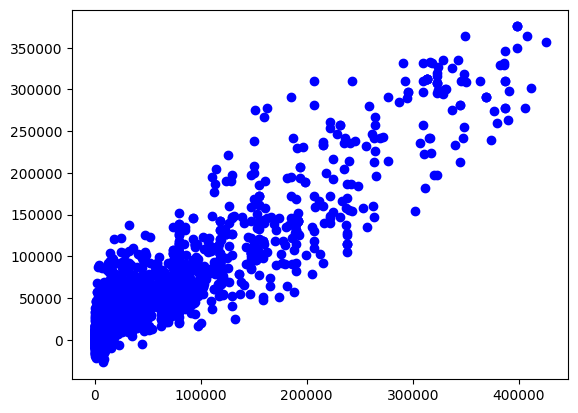

In [21]:

plt.scatter(y_train_v2, y_predict_train_v2, color='blue', label='Scatter Plot')


In [70]:
salida.to_excel("../output/salida_modelo_completo_xgb.xlsx")